In [2]:
import numpy as np
from pyDOE import *
import matplotlib.pyplot as plt
from numpy.linalg import *
import torch
import pandas as pd
from sklearn.preprocessing import LabelBinarizer 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Problem 1.(1)

$\text{According to Bayes rule: }$
\begin{align}
\hat{y} &= \text{argmax}P(y\vert x) \backsim \text{argmax}P(x\vert y)P(y)
\end{align}

$\text{A binary classification itself is a Bernoulli Experiment and }P(y = 1) = \frac{1}{2}\text{ , so}$

\begin{align}
P(y) &=(\frac{1}{2})^y(1-\frac{1}{2})^{1-y}=\frac{1}{2}\\[5pt]
\end{align}

\begin{align}
log(\hat{y}) &= \text{argmax }log(P(y\vert x)) = \text{argmax }log(P(x\vert y)P(y))\\[5pt]
& = \text{argmax}\left(\text{log } P(x\vert y) + \text{log} P(y)\right)\\[5pt]
\end{align}

$\text{The log likelihood function of joint is: } L(\theta) = log\Pi_{i = 1}^N P(x_i,y_i) = \Sigma_{i=1}^Nlog[P(x_i\vert y_i)P(y_i)]$

\begin{align}
\Sigma_{i = 1}^N\text{log}[(P(x_i\vert y_i)P(y_i))] &=\Sigma_{i = 1}^N\left[\text{log } P(x_i\vert y_i) + \text{log} P(y_i)\right] \\[5pt]
& = \Sigma_{i = 1}^N\left[\text{log }N(\mu_0, \Sigma, g)^{y_i} + \text{log }N(\mu_1, \Sigma, g)^{1-y_i}+log\frac{1}{2}\right]\\[5pt]
& =  \Sigma_{i = 1}^N\left[(y_i)\text{log }N(\mu_0, \Sigma, g)+ (1-y_i)\text{log }N(\mu_1, \Sigma, g)+log\frac{1}{2}\right]\\[5pt]
\end{align}


$\text{where }N(\mu_k, \Sigma, g) = c_k\cdot exp(-g((x-\mu_k)^T\Sigma^{-1}(x-\mu_k)$<br>
$So,$
\begin{align}
\Sigma_{i = 1}^N\text{log}[(P(x_i\vert y_i)P(y_i))] 
& = =  \Sigma_{i = 1}^N\left[-(y_i)\cdot g[(x_i-\mu_0)^T\Sigma^{-1}(x_i-\mu_0)]-\\[5pt](1-y_i)g[(x_i-\mu_1)^T\Sigma^{-1}(x_i-\mu_1)]+log\frac{1}{2}\right]\\[5pt]
\end{align}

# Problem 1.(2) 

$\text{The decision boundary is where: }$
$$ P(y_i = 0\vert x) = P(y_i = 1\vert x)$$
$\text{Since the covariance is shared between classes: }$
\begin{align}
\Sigma_{i = 1}^{N}\left [log\frac{1}{2}-g[(x_i-\mu_0)^T\Sigma^{-1}(x_i-\mu_0)]\right] &=\Sigma_{i = 1}^{N}\left [log\frac{1}{2}-g[(x_i-\mu_1)^T\Sigma^{-1}(x_i-\mu_1)]\right] \\[5pt]
N \cdot log\frac{1}{2}-g[(x-\mu_0)^T\Sigma^{-1}(x-\mu_0)] &=N \cdot log\frac{1}{2}-g[(x-\mu_1)^T\Sigma^{-1}(x-\mu_1)]\\[5pt]
g(x^T\Sigma^{-1}x - 2\mu_0^T\Sigma^{-1}+ \mu_0^T\Sigma^{-1}\mu_0) & = g(x^T\Sigma^{-1}x - 2\mu_1^T\Sigma^{-1}+ \mu_1^T\Sigma^{-1}\mu_1)\\[5pt]
 g\left[(2(u_0-u_1)^T\Sigma^{-1})x-(u_0-u_1)^T\Sigma^{-1}(u_0-u_1) \right] & = 0\\[5pt]
\end{align}
$\text{So the decision boundary is a linear function }$

\begin{align}
 ax+b & =(2(u_0-u_1)^T\Sigma^{-1})x-(u_0-u_1)^T\Sigma^{-1}(u_0-u_1) \\[5pt]
a &= 2(u_0-u_1)^T\Sigma^{-1}\\[5pt]
b &= -(u_0-u_1)^T\Sigma^{-1}(u_0-u_1)
\end{align}

# Problem 2.(1) Logistic Regression

In [4]:
# Read data
dataset = np.load('Data.npy', allow_pickle=True).item()
X = dataset['X']
Y = dataset['Y']

def split_sample(X, Y, n):
    n = int(X.shape[0]*n)
    X_train  = X[0:n, :].astype('float32')
    Y_train = Y[0:n, :].astype('float32')
    X_test  = X[n:, :].astype('float32')
    Y_test = Y[n:, :].astype('float32')
    
    X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
    
    X_training = torch.cat((torch.from_numpy(X_train), torch.ones(X_train.shape[0],1)), 1)
    X_testing = torch.cat((torch.from_numpy(X_test), torch.ones(X_test.shape[0],1)),1)
    Y_training = torch.from_numpy(Y_train)
    
    return X_training, Y_training, X_testing, Y_test


def Adam(learning_rate, it, m, v, w):
    '''Adam optimization'''
    theta_one = 0.9
    theta_two = 0.999
    epsilon = 1e-8
    m = theta_one * m + (1 - theta_one) * w.grad
    v = theta_two * v + (1 - theta_two) * (w.grad).pow(2)
    m_hat = m / (1 - theta_one ** (it + 1))
    v_hat = v / (1 - theta_two ** (it+ 1))
    w -= learning_rate * m_hat / (torch.sqrt(v_hat) + epsilon)
    return m, v, w

# Hyperparameters
learning_rate = 1e-3

In [5]:
#split sample
X_training, Y_training, X_testing, Y_test = split_sample(X, Y, 0.75)

# Initialize weights and m/v for Adam
w1 = torch.cat((torch.randn(10,1)* ((2/11)**0.5), torch.zeros(1, 1)), 0)
w1.requires_grad_(True)

m1 = torch.zeros(w1.size()) 
v1 = torch.zeros(w1.size())

# define forward pass
def forward(X, w1):
    '''Forward propagation'''
    O1 = X.mm(w1)
    y_pred = torch.sigmoid(O1)
#     for i in range (y_pred.shape[0]):
#         y_pred[i] = 1 if y_pred[i] > 0.5 else 0
    return y_pred

accc = []
# Iterations
for it in range(2500):
    # Setup model and calculate predicted f
    y_pred = forward(X_training, w1)
    
    # Compute BCE_LOSS
    n = y_pred.shape[0]
    loss = (-1/n)*((torch.log(y_pred).t()).mm(Y_training)+(torch.log(1-y_pred).t()).mm(1-Y_training))

    # Backward pass
    loss.backward()
    
    

    # update weights by Adam optimization
    with torch.no_grad(): 
        m1, v1, w1 = Adam(learning_rate, it, m1, v1, w1)
        w1.grad.zero_()

# loss of SGD decreases slower than Adam so didn't use
#     with torch.no_grad(): 
#         w1 -= learning_rate * w1.grad
#         w1.grad.zero_()


In [9]:
# Accuracy and confusion matrix.
Y_pred = forward(X_testing,w1).detach().numpy()
for i in range (Y_pred.shape[0]):
    Y_pred[i] = 0 if Y_pred[i] <0.5 else 1
c_met, acc = confusion_matrix(Y_test,Y_pred.round())
print(c_met.shape)

acc = accuracy_score(Y_test,Y_pred)
confusion_table = pd.DataFrame(c_met,columns=['       actual_positive','   actual negative'],index=['predicted positive','predicted negative'])
print('accuracy = ' + str(acc))
print(confusion_table)

(2, 2)
accuracy = 0.826036866359447
                           actual_positive     actual negative
predicted positive                     403                   1
predicted negative                     150                 314


In [13]:
def confusion_matrix(Y_pred, Y_test):
    pp_ap = 0           # predicted positive, actual positve
    pp_an = 0           # predicted positive, actual negative 
    pn_an = 0           # predicted negative, actual negative 
    pn_ap = 0           # predicted negative, actual positive 
    
    for i in range(Y_pred.shape[0]):
        if (Y_pred[i] == 0 && Y_test[i] == 0):
            pn_an +=1
        if (Y_pred[i] == 0 && Y_test[i] == 1):
            pn_ap += 1   
        if (Y_pred[i] == 1 && Y_test[i] == 1):
            pp_ap += 1 
        if (Y_pred[i] == 1 && Y_test[i] == 0):
            pp_an += 1
    confusion_matrix = np.zeros((2, 2))
    confusion_matrix[0][0] = pp_ap
    confusion_matrix[0][1] = pp_an
    confusion_matrix[1][0] = pn_ap
    confusion_matrix[1][1] = pn_an
    accuracy = ((pp_ap+pn_an)/Y_pred.shape[0]).round(4)
    
    return accuracy, confusion_matrix

SyntaxError: invalid syntax (<ipython-input-13-6f3964b1b64b>, line 8)

# Problem 2.(2)

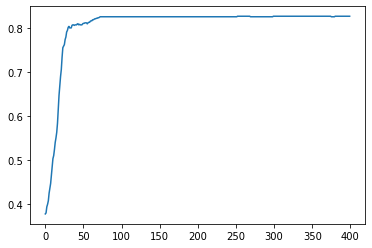

399 0.3552274703979492


In [360]:
#split sample
X_training, Y_training, X_testing, Y_test = split_sample(X, Y, 0.75)

# Define initialize weights and m/v
w1 = torch.cat((torch.randn(10,100)* ((2/110)**0.5), torch.zeros(1, 100)), 0)           #Add bias
w2 = torch.cat((torch.randn(100,1)* ((2/101)**0.5), torch.zeros(1, 1)), 0)

w1.requires_grad_(True)
w2.requires_grad_(True)


m1 = torch.zeros(w1.size()) 
v1 = torch.zeros(w1.size())
m2 = torch.zeros(w2.size()) 
v2 = torch.zeros(w2.size())


# define forward pass
def forward22(X, w1, w2):
    '''Forward propagation'''
    O1 = X.mm(w1)
    h1 = torch.cat((torch.tanh(O1),torch.ones(O1.size()[0],1)), 1)        # Add bias
    O2 = torch.sigmoid(h1.mm(w2))
    return O2

accc=[]
# Iterations
for it in range(400):
    # Setup model and calculate predicted f
    y_pred = forward22(X_training, w1, w2)

    
# Compute BCE_LOSS
    n = y_pred.shape[0]
    loss = (-1/n)*((torch.log(y_pred).t()).mm(Y_training)+(torch.log(1-y_pred).t()).mm(1-Y_training))
    
    # Backward pass
    loss.backward()

    # update weights by Adam optimization
    with torch.no_grad(): 
        m1, v1, w1 = Adam(learning_rate, it, m1, v1, w1)
        m2, v2, w2 = Adam(learning_rate, it, m2, v2, w2)
        w1.grad.zero_()
        w2.grad.zero_()
        
    # Accuracy and confusion matrix.
    Y_pred = forward22(X_testing,w1, w2).detach().numpy()
    for i in range (Y_pred.shape[0]):
        Y_pred[i] = 0 if Y_pred[i] < 0.5 else 1
    c_met = confusion_matrix(Y_test,Y_pred)
    acc = accuracy_score(Y_test,Y_pred)
    accc.append(acc)

x = range(0,400)
plt.plot(x, accc)
plt.show()
print(it,loss.item())

In [361]:
# Accuracy and confusion matrix.
Y_pred = forward22(X_testing,w1, w2).detach().numpy()
for i in range (Y_pred.shape[0]):
    Y_pred[i] = 0 if Y_pred[i] <0.5 else 1
c_met = confusion_matrix(Y_test,Y_pred)
acc = accuracy_score(Y_test,Y_pred)
confusion_table = pd.DataFrame(c_met,columns=['actual_positive','actual negative'],index=['predicted positive','predicted negative'])
print('accuracy = ' + str(acc.round(5)))
print(confusion_table)

accuracy = 0.82719
                    actual_positive  actual negative
predicted positive              401                3
predicted negative              147              317


# Problem 2.(3)

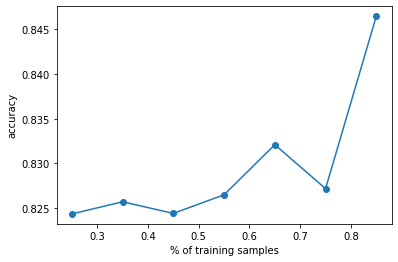

399 0.3591156303882599


In [375]:
N = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]
accc=[]

for n in N:
    
    # split samples
    X_training, Y_training, X_testing, Y_test = split_sample(X, Y, n)

    # Define initialize weights and m/v
    w1 = torch.cat((torch.randn(10,100)* ((2/110)**0.5), torch.zeros(1, 100)), 0)           #Add bias
    w2 = torch.cat((torch.randn(100,1)* ((2/101)**0.5), torch.zeros(1, 1)), 0)

    w1.requires_grad_(True)
    w2.requires_grad_(True)

    m1 = torch.zeros(w1.size()) 
    v1 = torch.zeros(w1.size())
    m2 = torch.zeros(w2.size()) 
    v2 = torch.zeros(w2.size())


    # define forward pass
    def forward22(X, w1, w2):
        '''Forward propagation'''
        O1 = X.mm(w1)
        h1 = torch.cat((torch.tanh(O1),torch.ones(O1.size()[0],1)), 1)        # Add bias
        O2 = torch.sigmoid(h1.mm(w2))
        return O2

    
    # Iterations
    for it in range(400):
        # Setup model and calculate predicted f
        y_pred = forward22(X_training, w1, w2)


    # Compute BCE_LOSS
        n = y_pred.shape[0]
        loss = (-1/n)*((torch.log(y_pred).t()).mm(Y_training)+(torch.log(1-y_pred).t()).mm(1-Y_training))

        # Backward pass
        loss.backward()

        # update weights by Adam optimization
        with torch.no_grad(): 
            m1, v1, w1 = Adam(learning_rate, it, m1, v1, w1)
            m2, v2, w2 = Adam(learning_rate, it, m2, v2, w2)
            w1.grad.zero_()
            w2.grad.zero_()

    # Accuracy and confusion matrix.
    Y_pred = forward22(X_testing,w1, w2).detach().numpy()
    for i in range (Y_pred.shape[0]):
        Y_pred[i] = 0 if Y_pred[i] < 0.5 else 1
    c_met = confusion_matrix(Y_test,Y_pred)
    acc = accuracy_score(Y_test,Y_pred)
    accc.append(acc)

plt.plot(N, accc, '-o')
plt.xlabel('% of training samples')
plt.ylabel('accuracy')
plt.show()
print(it,loss.item())

# Problem 3

In [109]:
def generate_samples(N):
    '''Generalize and initialize N train samples'''
    
    # Generate N test samples.
    train_s = 4 * lhs(2, N) + 50
    train_f = np.multiply(np.cos(np.pi*train_s[:, 0]), np.cos(np.pi*train_s[:, 1]))[:, None]
    
    # Initialize and add bias (b = 0 initially)
    train_s = np.hstack([(train_s - np.mean(train_s,axis = 0))/ np.std(train_s,axis = 0),np.ones((train_s.shape[0],1))]).astype('float32')
    train_f = (train_f - np.mean(train_f,axis = 0))/ np.std(train_f,axis = 0).astype('float32')
    train_s = torch.from_numpy(train_s)
    train_f = torch.from_numpy(train_f)
    return train_s, train_f

# Generate 100 test samples
test_s = (4 * lhs(2,100) + 50).astype('float32')
test_f = np.multiply(np.cos(np.pi*test_s[:, 0]), np.cos(np.pi*test_s[:, 1]))[:, None]
test_s = np.hstack([(test_s - np.mean(test_s,axis = 0))/ np.std(test_s,axis = 0),np.ones((test_s.shape[0],1))]).astype('float32')
test_f = (test_f - np.mean(test_f,axis = 0))/ np.std(test_f,axis = 0).astype('float32')
test_s = torch.from_numpy(test_s)

def Adam(learning_rate, it, m, v, w):
    '''Adam optimization'''
    theta_one = 0.9
    theta_two = 0.999
    epsilon = 1e-8
    m = theta_one * m + (1 - theta_one) * w.grad
    v = theta_two * v + (1 - theta_two) * (w.grad).pow(2)
    m_hat = m / (1 - theta_one ** (it + 1))
    v_hat = v / (1 - theta_two ** (it+ 1))
    w -= learning_rate * m_hat / (torch.sqrt(v_hat) + epsilon)
    return m, v, w

def error(pred_f, test_f):
    '''Calculate relative L2 error'''
    error = pred_f - test_f
    relative_error = np.linalg.norm(error) / np.linalg.norm(test_f)
    return relative_error

In [104]:
errors = []
N =  [10, 100, 1000, 5000, 10000]
learning_rate = 1e-3

for i in range(5):
    
    # Initialize weights and m/v for Adam
    w1 = torch.cat((torch.randn(2,50)* ((1/26)**0.5), torch.zeros(1, 50)), 0)
    w2 = torch.cat((torch.randn(50,50)* ((1/50)**0.5), torch.zeros(1, 50)), 0)
    w3 = torch.cat((torch.randn(50,1)* ((2/51)**0.5), torch.zeros(1, 1)), 0)
    w1.requires_grad_(True)
    w2.requires_grad_(True)
    w3.requires_grad_(True)

    m1 = torch.zeros(w1.size()) 
    v1 = torch.zeros(w1.size())
    m2 = torch.zeros(w2.size()) 
    v2 = torch.zeros(w2.size())
    m3 = torch.zeros(w3.size()) 
    v3 = torch.zeros(w3.size())


    # define forward pass
    def forward3(X, w1, w2, w3):
        '''Forward propagation'''
        O1 = X.mm(w1)
        h1 = torch.cat((torch.tanh(O1),torch.ones(O1.size()[0],1)), 1)        # Add bias
        O2 = h1.mm(w2)
        h2 = torch.cat((torch.tanh(O2),torch.ones(O2.size()[0],1)), 1)      # Add bias
        pred_f  = h2.mm(w3)
        return pred_f

    # Generate train samples
    train_s, train_f = generate_samples(N[i])

    # Iterations
    for it in range(5000):
        # Setup model and calculate predicted f
        pred_f = forward3(train_s, w1, w2, w3)

        #loss = MSE_LOSS
        n = train_s.size()[0]
        loss = (1/n)*(pred_f - train_f).pow(2).sum()

        # Backward pass

        loss.backward()

        # update weights by Adam optimization
        with torch.no_grad(): 
            m1, v1, w1 = Adam(learning_rate, it, m1, v1, w1)
            m2, v2, w2 = Adam(learning_rate, it, m2, v2, w2)
            m3, v3, w3 = Adam(learning_rate, it, m3, v3, w3)
            w1.grad.zero_()
            w2.grad.zero_()
            w3.grad.zero_()
    
    # Calculate error
    pred_f = forward3(test_s, w1, w2, w3).detach().numpy()
    errors.append(error(pred_f, test_f))
    # Check
    print(it,loss.item())
    print(errors)

4999 1.3928536126293923e-07
[1.8787508]
4999 1.2975431289932774e-05
[1.8787508, 0.42969793]
4999 0.00017560965614489023
[1.8787508, 0.42969793, 0.16507916]
4999 0.00032730532737686006
[1.8787508, 0.42969793, 0.16507916, 0.14804953]
4999 0.000146479534322745
[1.8787508, 0.42969793, 0.16507916, 0.14804953, 0.14185783]


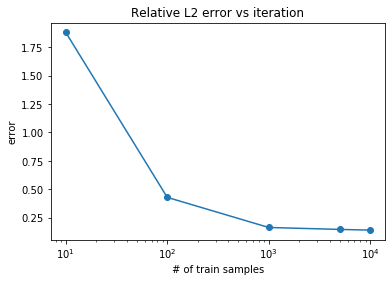

In [108]:
plt.figure()
plt.plot(N,errors,marker='o')
plt.title('Relative L2 error vs iteration')
plt.xscale('log')
plt.xlabel('# of train samples')
plt.ylabel('error')
plt.show()

In [115]:
errors = []
N =  [10, 100, 1000, 5000, 1000]
learning_rate = 1e-3

for i in range(5):
    
    # Initialize weights and m/v for Adam
    w1 = torch.cat((torch.randn(2,50)* ((1/26)**0.5), torch.zeros(1, 50)), 0)
    w2 = torch.cat((torch.randn(50,50)* ((1/50)**0.5), torch.zeros(1, 50)), 0)
    w3 = torch.cat((torch.randn(50,1)* ((2/51)**0.5), torch.zeros(1, 1)), 0)
    w1.requires_grad_(True)
    w2.requires_grad_(True)
    w3.requires_grad_(True)

    # def forward pass
    def forward(X, w1, w2, w3):
        '''Forward propagation'''
        O1 = X.mm(w1)
        h1 = torch.cat((torch.tanh(O1),torch.ones(O1.size()[0],1)), 1)        # Add bias
        O2 = h1.mm(w2)
        h2 = torch.cat((torch.tanh(O2),torch.ones(O2.size()[0],1)), 1)      # Add bias
        pred_f  = h2.mm(w3)
        return pred_f

    # Generate train samples
    train_s, train_f = generate_samples(N[i])

    # Iterations
    for it in range(5000):
        # Setup model and calculate predicted f
        pred_f = forward(train_s, w1, w2, w3)

        # Compute and print loss
        #loss = MSE_LOSS(pred_f, train_f)
        loss = (1/n)*(pred_f - train_f).pow(2).sum()

        # Backward pass
        loss.backward()

        # update weights by SGD optimization
        with torch.no_grad(): 
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad
            w3 -= learning_rate * w3.grad
            w1.grad.zero_()
            w2.grad.zero_()
            w3.grad.zero_()
    
    # Calculate error
    pred_f = forward(test_s, w1, w2, w3).detach().numpy()
    errors.append(error(pred_f, test_f))
    # Check
    print(it,loss.item())
    print(errors)

4999 0.003679346620458638
[1.0565984]
4999 0.03679766235890274
[1.0565984, 1.0112159]
4999 0.3836043679765222
[1.0565984, 1.0112159, 0.99924326]
4999 1.9206813375753322
[1.0565984, 1.0112159, 0.99924326, 1.0015724]
4999 0.3829360640049371
[1.0565984, 1.0112159, 0.99924326, 1.0015724, 1.0047376]


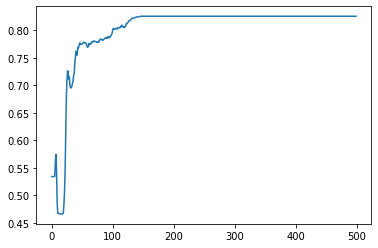

499 0.3704920709133148


In [304]:
#2.2
# Define weights
w1 = torch.cat((torch.randn(10,50)* ((1/30)**0.5), torch.zeros(1, 50)), 0)           #Add bias
w2 = torch.cat((torch.randn(50,50)* ((1/50)**0.5), torch.zeros(1, 50)), 0)
w3 = torch.cat((torch.randn(50,1)* ((2/51)**0.5), torch.zeros(1, 1)), 0)
w1.requires_grad_(True)
w2.requires_grad_(True)
w3.requires_grad_(True)

m1 = torch.zeros(w1.size()) 
v1 = torch.zeros(w1.size())
m2 = torch.zeros(w2.size()) 
v2 = torch.zeros(w2.size())
m3 = torch.zeros(w3.size()) 
v3 = torch.zeros(w3.size())


# define forward pass
def forward22(X, w1, w2, w3):
    '''Forward propagation'''
    O1 = X.mm(w1)
    h1 = torch.cat((torch.sigmoid(O1),torch.ones(O1.size()[0],1)), 1)        # Add bias
    O2 = h1.mm(w2)
    h2 = torch.cat((torch.sigmoid(O2),torch.ones(O2.size()[0],1)), 1)      # Add bias
    y_pred  = torch.sigmoid(h2.mm(w3))
    return y_pred

accc=[]
# Iterations
for it in range(500):
    # Setup model and calculate predicted f
    y_pred = forward22(X_training, w1, w2, w3)

    # Compute BCE_LOSS
    n = y_pred.shape[0]
    loss = (-1/n)*((torch.log(y_pred).t()).mm(Y_training)+(torch.log(1-y_pred).t()).mm(1-Y_training))

    
    # Backward pass
    loss.backward()

    # update weights by Adam optimization
    with torch.no_grad(): 
        m1, v1, w1 = Adam(learning_rate, it, m1, v1, w1)
        m2, v2, w2 = Adam(learning_rate, it, m2, v2, w2)
        m3, v3, w3 = Adam(learning_rate, it, m3, v3, w3)
        w1.grad.zero_()
        w2.grad.zero_()
        w3.grad.zero_()
    
    # Accuracy and confusion matrix.
    Y_pred = forward22(X_testing,w1, w2, w3).detach().numpy()
    for i in range (Y_pred.shape[0]):
        Y_pred[i] = 0 if Y_pred[i] < 0.5 else 1
    c_met = confusion_matrix(Y_test,Y_pred)
    acc = accuracy_score(Y_test,Y_pred)
    accc.append(acc)

x = range(0,500)
plt.plot(x, accc)
plt.show()
print(it,loss.item())
